# 1 Setup/Initialization

## 1.1 Import Libraries

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from google.colab import drive

In [ ]:
# Initialization
%matplotlib inline
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## 1.2 Import Dataset

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
col_names = ["ZONEID", "TIMESTAMP", "tclw (kg/m**2)", "tciw (kg/m**2)",
             "SP (Pa)", "r (%)", "TCC (0-1)", "10u (m/s)", "10v (m/s)",
             "2T (K)", "SSRD (J/m**2)", "STRD (J/m**2)", "TSR (J/m**2)",
             "TP (m)", "POWER"]
train_df = pd.read_csv("/content/drive/MyDrive/CS 458 Data Mining/Solar Power Generation Forecast/solar_training.csv",
                          header=0, names=col_names)
test_df = pd.read_csv("/content/drive/MyDrive/CS 458 Data Mining/Solar Power Generation Forecast/solar_test.csv",
                      header=0, names=col_names)
test_df.dropna(inplace=True)

## 1.3 Prepare Dataframes

In [ ]:
train1_index = train_df.query("ZONEID == 1").index
train2_index = train_df.query("ZONEID == 2").index
train3_index = train_df.query("ZONEID == 3").index

test1_index = test_df.query("ZONEID == 1").index
test2_index = test_df.query("ZONEID == 2").index
test3_index = test_df.query("ZONEID == 3").index

In [ ]:
train_zoneid = train_df.pop("ZONEID")
train_timestamp = pd.to_datetime(train_df.pop("TIMESTAMP"), format="%Y%m%d %H:%M")
train_df.dtypes

tclw (kg/m**2)    float64
tciw (kg/m**2)    float64
SP (Pa)           float64
r (%)             float64
TCC (0-1)         float64
10u (m/s)         float64
10v (m/s)         float64
2T (K)            float64
SSRD (J/m**2)     float64
STRD (J/m**2)     float64
TSR (J/m**2)      float64
TP (m)            float64
POWER             float64
dtype: object

In [ ]:
test_zoneid = test_df.pop("ZONEID").astype("int64")
test_timestamp = pd.to_datetime(test_df.pop("TIMESTAMP"), format="%Y%m%d %H:%M")
test_df.dtypes

tclw (kg/m**2)    float64
tciw (kg/m**2)    float64
SP (Pa)           float64
r (%)             float64
TCC (0-1)         float64
10u (m/s)         float64
10v (m/s)         float64
2T (K)            float64
SSRD (J/m**2)     float64
STRD (J/m**2)     float64
TSR (J/m**2)      float64
TP (m)            float64
POWER             float64
dtype: object

In [ ]:
try:
    tf.convert_to_tensor(train_df)
    tf.convert_to_tensor(test_df)
    print("Success!")
except Exception as e:
    raise e

Success!


# 2 Preprocessing Data

## 2.1 Inspection of Data
Analyze data of zone 1

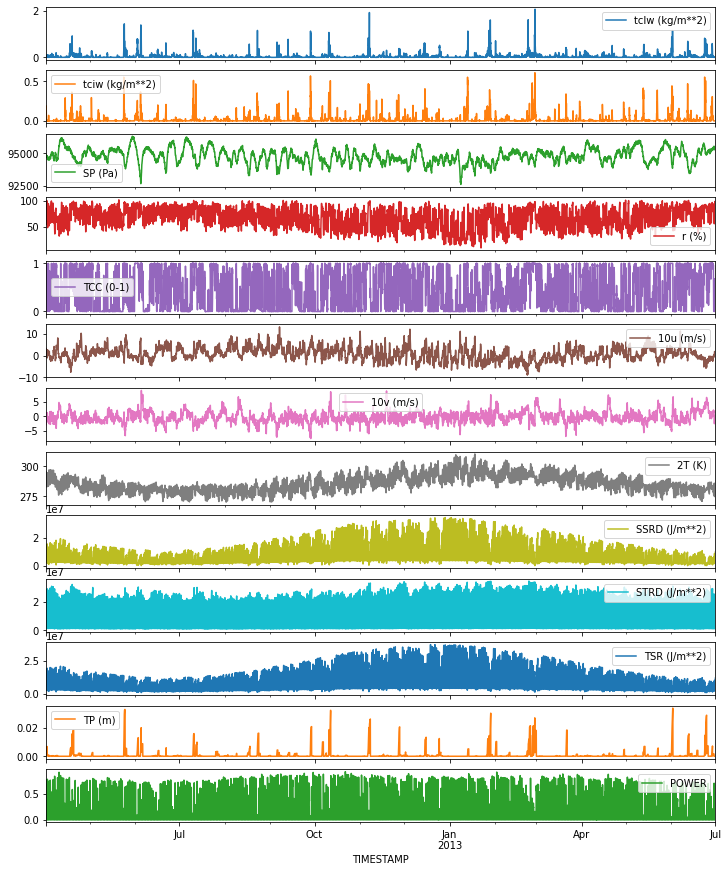

In [ ]:
# Over entire duration
df = train_df.iloc[train1_index]
df.index = train_timestamp.iloc[train1_index]
axs = df.plot(subplots=True, figsize=(12,15))
# axs[0].get_figure().savefig(f"total_inspect.png")

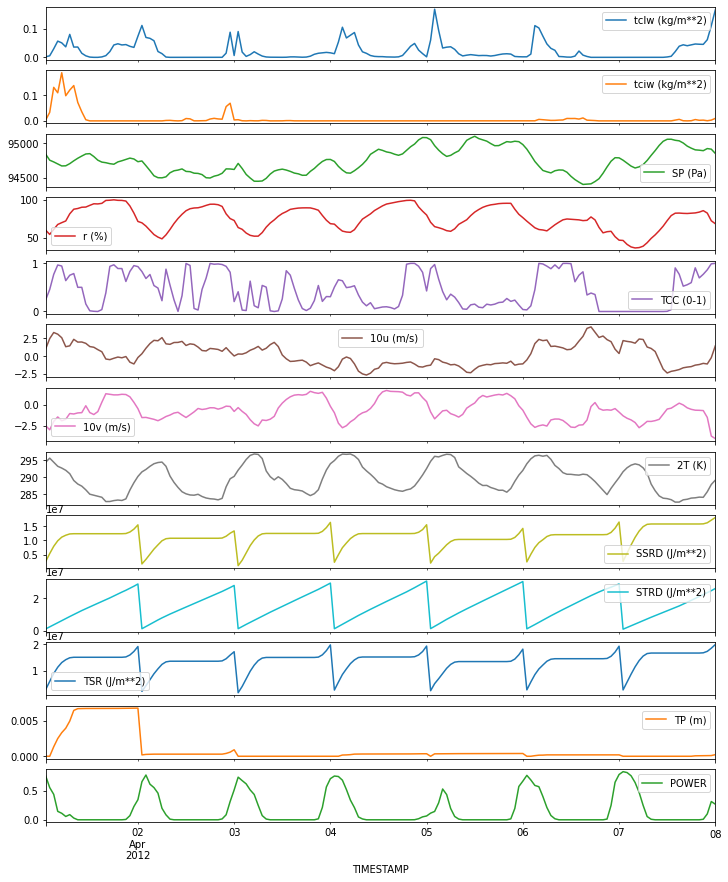

In [ ]:
# Over first week
axs = df.iloc[:24*7].plot(subplots=True, figsize=(12,15))
# axs[0].get_figure().savefig("week_inspect.png")

In [ ]:
# Summary statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tclw (kg/m**2),10944.0,3.889433e-02,1.138095e-01,0.000000,0.000000e+00,2.349854e-03,3.238106e-02,2.068974e+00
tciw (kg/m**2),10944.0,1.565516e-02,4.971535e-02,0.000000,0.000000e+00,8.130000e-05,5.745411e-03,6.066458e-01
SP (Pa),10944.0,9.477877e+04,5.725483e+02,92587.812500,9.439694e+04,9.476612e+04,9.518114e+04,9.630806e+04
r (%),10944.0,6.906619e+01,1.948787e+01,10.228189,5.465900e+01,7.208055e+01,8.583268e+01,1.017909e+02
TCC (0-1),10944.0,4.159219e-01,3.981049e-01,0.000000,7.354736e-03,2.982025e-01,8.552530e-01,1.000007e+00
10u (m/s),10944.0,7.318901e-01,2.726314e+00,-8.908603,-1.071350e+00,5.216699e-01,2.350360e+00,1.305672e+01
10v (m/s),10944.0,-1.831618e-01,1.922577e+00,-7.636124,-1.451407e+00,-3.780746e-01,9.789636e-01,8.979910e+00
2T (K),10944.0,2.851357e+02,7.177476e+00,270.266357,2.797714e+02,2.842356e+02,2.898708e+02,3.100623e+02
SSRD (J/m**2),10944.0,1.189265e+07,6.451321e+06,187820.375000,7.201339e+06,1.058380e+07,1.652278e+07,3.410930e+07
STRD (J/m**2),10944.0,1.381978e+07,7.719015e+06,865972.812500,7.316644e+06,1.372081e+07,1.994981e+07,3.417538e+07


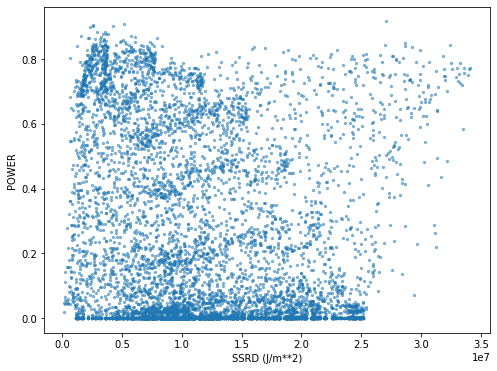

In [ ]:
ax = df.plot.scatter("SSRD (J/m**2)", "POWER", marker=".", alpha=0.5)
# ax.get_figure().savefig("ssrd_scatter.png")

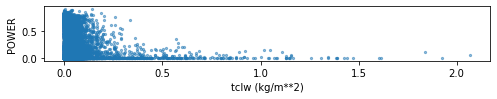

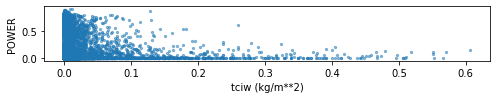

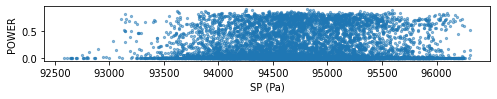

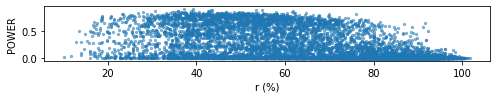

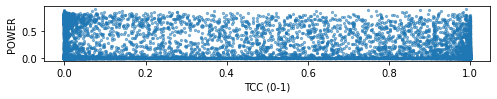

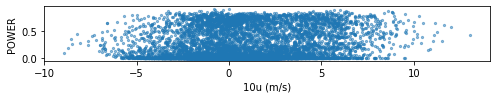

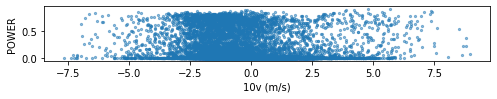

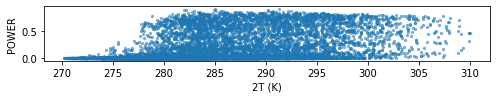

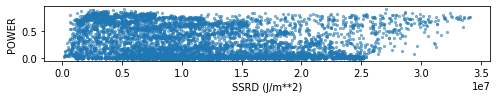

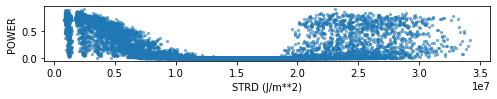

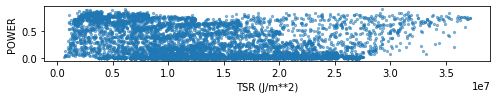

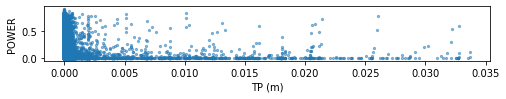

In [ ]:
for col in df.columns.drop("POWER"):
    df.plot.scatter(col, "POWER", figsize=(8, 1), marker=".", alpha=0.5)

### 2.1.1 Correlation and Coefficient of Determination Analysis

In [ ]:
measures = {"r": [], "r**2": []}
col_names = df.columns.drop("POWER")
for col in col_names:
    r = df["POWER"].corr(df[col])
    measures["r"].append(r)
    measures["r**2"].append(r*r)
measures_df = pd.DataFrame(measures, index=col_names)
measures_df.sort_values(by="r**2", ascending=False)

,r,r**2
r (%),-0.535012,0.286238
2T (K),0.429040,0.184075
STRD (J/m**2),-0.351722,0.123708
TSR (J/m**2),-0.183322,0.033607
10u (m/s),0.180212,0.032476
SSRD (J/m**2),-0.142930,0.020429
10v (m/s),-0.137443,0.018891
TP (m),-0.115461,0.013331
tciw (kg/m**2),-0.092360,0.008530
TCC (0-1),-0.084965,0.007219


## 2.2 Feature Engineering

### 2.2.1 Time Signals and Hour of Day
Convert timestamps to time signals. Extract hour of day.

In [ ]:
day = 24*60*60
year = (365.2425)*day

train_timestamp_s = train_timestamp.map(pd.Timestamp.timestamp)
test_timestamp_s = test_timestamp.map(pd.Timestamp.timestamp)

train_df["Day sin"] = np.sin(train_timestamp_s * (2 * np.pi / day))
train_df["Day cos"] = np.cos(train_timestamp_s * (2 * np.pi / day))
train_df["Year sin"] = np.sin(train_timestamp_s * (2 * np.pi / year))
train_df["Year cos"] = np.cos(train_timestamp_s * (2 * np.pi / year))
train_df["hour"] = train_timestamp.map(lambda t: t.hour)

test_df["Day sin"] = np.sin(test_timestamp_s * (2 * np.pi / day))
test_df["Day cos"] = np.cos(test_timestamp_s * (2 * np.pi / day))
test_df["Year sin"] = np.sin(test_timestamp_s * (2 * np.pi / year))
test_df["Year cos"] = np.cos(test_timestamp_s * (2 * np.pi / year))
test_df["hour"] = test_timestamp.map(lambda t: t.hour)

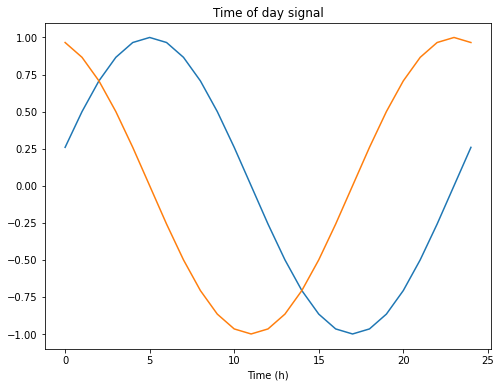

In [ ]:
plt.plot(np.array(train_df["Day sin"])[:25])
plt.plot(np.array(train_df["Day cos"])[:25])
plt.xlabel("Time (h)")
plt.title("Time of day signal")
# plt.savefig("day_signal.png")

Text(0.5, 1.0, 'Time of year signal')

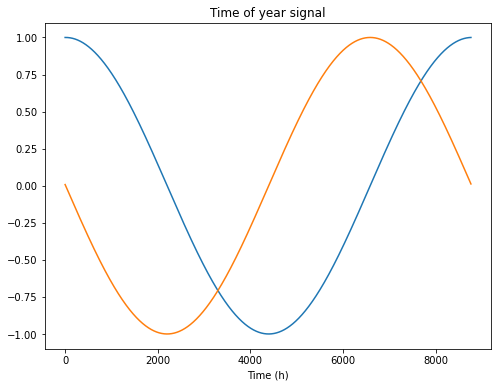

In [ ]:
plt.plot(np.array(train_df["Year sin"])[:365*24 + 1])
plt.plot(np.array(train_df["Year cos"])[:365*24 + 1])
plt.xlabel("Time (h)")
plt.title("Time of year signal")

### 2.2.2 Average SSRD
`SSRD (J/m**2)` is the solar irridiance at a particular hour. The average solar irridiance between an hour `SSRD (W/m**2)` has a clearer correlation.

In [ ]:
ssrd_avg = pd.Series(dtype=np.float64)
for zone_index in (train1_index, train2_index, train3_index):
    ssrd_t0 = train_df.loc[zone_index]["SSRD (J/m**2)"]
    ssrd_t1 = ssrd_t0.copy()
    ssrd_t1.index = ssrd_t0.index - 1
    ssrd_avg = ssrd_avg.append((ssrd_t1.drop(index=ssrd_t1.index[0]) - ssrd_t0)/3600)
    ssrd_avg.iloc[-1] = 0
for i in range(23, ssrd_avg.size, 24):
    ssrd_avg.iloc[i] = ssrd_avg.iloc[i - 1]
train_df["SSRD (W/m**2)"] = ssrd_avg
train_df["SSRD (W/m**2)"]

0        771.739722
1        712.693056
2        538.536667
3        356.271389
4        186.852778
            ...    
32827      0.000000
32828     21.451667
32829    153.716389
32830    294.343889
32831    294.343889
Name: SSRD (W/m**2), Length: 32832, dtype: float64

In [ ]:
ssrd_avg = pd.Series(dtype=np.float64)
for zone_index in (test1_index, test2_index, test3_index):
    ssrd_t0 = test_df.loc[zone_index]["SSRD (J/m**2)"]
    ssrd_t1 = ssrd_t0.copy()
    ssrd_t1.index = ssrd_t0.index - 1
    ssrd_avg = ssrd_avg.append((ssrd_t1.drop(index=ssrd_t1.index[0]) - ssrd_t0)/3600)
    ssrd_avg.iloc[-1] = 0
for i in range(23, ssrd_avg.size, 24):
    ssrd_avg.iloc[i] = ssrd_avg.iloc[i - 1]
test_df["SSRD (W/m**2)"] = ssrd_avg 
test_df["SSRD (W/m**2)"]

0        506.244722
1        517.823056
2        462.833056
3        350.386389
4        201.827500
            ...    
26275      0.000000
26276     21.564167
26277    162.231389
26278    302.553611
26279    302.553611
Name: SSRD (W/m**2), Length: 26280, dtype: float64

### 2.2.3 Average STRD

In [ ]:
strd_avg = pd.Series(dtype=np.float64)
for zone_index in (train1_index, train2_index, train3_index):
    strd_t0 = train_df.loc[zone_index]["STRD (J/m**2)"]
    strd_t1 = strd_t0.copy()
    strd_t1.index = strd_t0.index - 1
    strd_avg = strd_avg.append((strd_t1.drop(index=strd_t1.index[0]) - strd_t0)/3600)
    strd_avg.iloc[-1] = 0
for i in range(23, strd_avg.size, 24):
    strd_avg.iloc[i] = strd_avg.iloc[i - 1]
train_df["STRD (W/m**2)"] = strd_avg
train_df["STRD (W/m**2)"]

0        345.618056
1        342.938611
2        344.491111
3        370.243333
4        362.231944
            ...    
32827    253.293333
32828    248.306667
32829    259.844444
32830    265.057778
32831    265.057778
Name: STRD (W/m**2), Length: 32832, dtype: float64

In [ ]:
strd_avg = pd.Series(dtype=np.float64)
for zone_index in (test1_index, test2_index, test3_index):
    strd_t0 = test_df.loc[zone_index]["STRD (J/m**2)"]
    strd_t1 = strd_t0.copy()
    strd_t1.index = strd_t0.index - 1
    strd_avg = strd_avg.append((strd_t1.drop(index=strd_t1.index[0]) - strd_t0)/3600)
    strd_avg.iloc[-1] = 0
for i in range(23, strd_avg.size, 24):
    strd_avg.iloc[i] = strd_avg.iloc[i - 1]
test_df["STRD (W/m**2)"] = strd_avg 
test_df["STRD (W/m**2)"]

0        264.296771
1        268.371667
2        270.100000
3        269.858056
4        263.074722
            ...    
26275    274.017778
26276    246.115556
26277    256.804444
26278    254.466667
26279    254.466667
Name: STRD (W/m**2), Length: 26280, dtype: float64

### 2.2.4 Average TSR

In [ ]:
tsr_avg = pd.Series(dtype=np.float64)
for zone_index in (train1_index, train2_index, train3_index):
    tsr_t0 = train_df.loc[zone_index]["TSR (J/m**2)"]
    tsr_t1 = tsr_t0.copy()
    tsr_t1.index = tsr_t0.index - 1
    tsr_avg = tsr_avg.append((tsr_t1.drop(index=tsr_t1.index[0]) - tsr_t0)/3600)
    tsr_avg.iloc[-1] = 0
for i in range(23, tsr_avg.size, 24):
    tsr_avg.iloc[i] = tsr_avg.iloc[i - 1]
train_df["TSR (W/m**2)"] = tsr_avg
train_df["TSR (W/m**2)"]

0        857.661389
1        830.499444
2        664.584167
3        492.744167
4        303.595833
            ...    
32827      0.000000
32828     36.864167
32829    196.403611
32830    348.179722
32831    348.179722
Name: TSR (W/m**2), Length: 32832, dtype: float64

In [ ]:
tsr_avg = pd.Series(dtype=np.float64)
for zone_index in (test1_index, test2_index, test3_index):
    tsr_t0 = test_df.loc[zone_index]["TSR (J/m**2)"]
    tsr_t1 = tsr_t0.copy()
    tsr_t1.index = tsr_t0.index - 1
    tsr_avg = tsr_avg.append((tsr_t1.drop(index=tsr_t1.index[0]) - tsr_t0)/3600)
    tsr_avg.iloc[-1] = 0
for i in range(23, tsr_avg.size, 24):
    tsr_avg.iloc[i] = tsr_avg.iloc[i - 1]
test_df["TSR (W/m**2)"] = tsr_avg
test_df["TSR (W/m**2)"]

0        553.912222
1        565.769722
2        512.948333
3        401.205278
4        247.778056
            ...    
26275      0.000000
26276     36.176389
26277    198.381111
26278    346.088056
26279    346.088056
Name: TSR (W/m**2), Length: 26280, dtype: float64

### 2.2.5 Average TP

In [ ]:
tp_avg = pd.Series(dtype=np.float64)
for zone_index in (train1_index, train2_index, train3_index):
    tp_t0 = train_df.loc[zone_index]["TP (m)"]
    tp_t1 = tp_t0.copy()
    tp_t1.index = tp_t0.index - 1
    tp_avg = tp_avg.append((tp_t1.drop(index=tp_t1.index[0]) - tp_t0)/3600)
    tp_avg.iloc[-1] = 0
for i in range(23, tp_avg.size, 24):
    tp_avg.iloc[i] = tp_avg.iloc[i - 1]
train_df["TP (m/s)"] = tp_avg
train_df["TP (m/s)"]

0        0.000000e+00
1        3.724628e-07
2        3.223950e-07
3        2.304711e-07
4        1.747081e-07
             ...     
32827    0.000000e+00
32828    0.000000e+00
32829    0.000000e+00
32830    0.000000e+00
32831    0.000000e+00
Name: TP (m/s), Length: 32832, dtype: float64

In [ ]:
tp_avg = pd.Series(dtype=np.float64)
for zone_index in (test1_index, test2_index, test3_index):
    tp_t0 = test_df.loc[zone_index]["TP (m)"]
    tp_t1 = tp_t0.copy()
    tp_t1.index = tp_t0.index - 1
    tp_avg = tp_avg.append((tp_t1.drop(index=tp_t1.index[0]) - tp_t0)/3600)
    tp_avg.iloc[-1] = 0
for i in range(23, tp_avg.size, 24):
    tp_avg.iloc[i] = tp_avg.iloc[i - 1]
test_df["TP (m/s)"] = tp_avg
test_df["TP (m/s)"]

0        0.000000e+00
1        0.000000e+00
2        0.000000e+00
3        0.000000e+00
4        0.000000e+00
             ...     
26275    0.000000e+00
26276    5.555556e-10
26277    0.000000e+00
26278    0.000000e+00
26279    0.000000e+00
Name: TP (m/s), Length: 26280, dtype: float64

### 2.2.3 Revisit Correlation and Coefficient of Determination Analysis

In [ ]:
df = train_df.iloc[train1_index]
measures = {"r": [], "r**2": []}
col_names = df.columns.drop("POWER")
print(col_names)
for col in col_names:
    r = df["POWER"].corr(df[col])
    measures["r"].append(r)
    measures["r**2"].append(r*r)
measures_df = pd.DataFrame(measures, index=col_names)
max_corr_cols = measures_df.sort_values(by="r**2", ascending=False).index
measures_df.loc[max_corr_cols]

Index(['tclw (kg/m**2)', 'tciw (kg/m**2)', 'SP (Pa)', 'r (%)', 'TCC (0-1)',
       '10u (m/s)', '10v (m/s)', '2T (K)', 'SSRD (J/m**2)', 'STRD (J/m**2)',
       'TSR (J/m**2)', 'TP (m)', 'Day sin', 'Day cos', 'Year sin', 'Year cos',
       'hour', 'SSRD (W/m**2)', 'STRD (W/m**2)', 'TSR (W/m**2)', 'TP (m/s)'],
      dtype='object')


,r,r**2
SSRD (W/m**2),0.893549,0.798431
TSR (W/m**2),0.887801,0.788190
Day cos,0.666064,0.443642
hour,-0.560316,0.313955
r (%),-0.535012,0.286238
2T (K),0.429040,0.184075
Day sin,0.381477,0.145525
STRD (J/m**2),-0.351722,0.123708
TSR (J/m**2),-0.183322,0.033607
10u (m/s),0.180212,0.032476


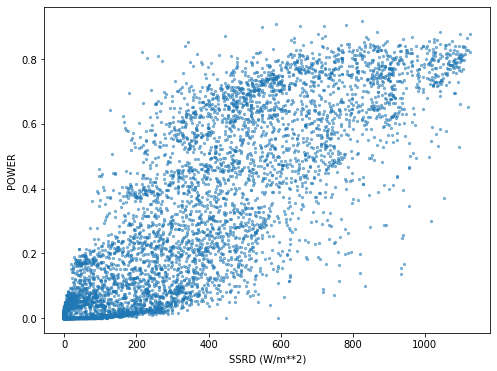

In [ ]:
df.plot.scatter("SSRD (W/m**2)", "POWER", marker=".", alpha=0.5)
plt.savefig("ssrd_avg_scatter.png")

## 2.3 Split the Data
Split training data 80:20 for training and validation set, respectively.

In [ ]:
column_index = {name: i for i, name in enumerate(train_df.columns)}

n_train1 = len(train1_index)
train1_df = train_df.loc[train1_index[0:int(n_train1*0.8)]]
val1_df = train_df.loc[train1_index[int(n_train1*0.8):]]
test1_df = test_df.loc[test1_index]

n_train2 = len(train2_index)
train2_df = train_df.loc[train2_index[0:int(n_train2*0.8)]]
val2_df = train_df.loc[train2_index[int(n_train2*0.8):]]
test2_df = test_df.loc[test2_index]

n_train3 = len(train3_index)
train3_df = train_df.loc[train3_index[0:int(n_train3*0.8)]]
val3_df = train_df.loc[train3_index[int(n_train3*0.8):]]
test3_df = test_df.loc[test3_index]

num_features = train_df.shape[1]

## 2.4 Normalize the Data
Power is already normalized.

In [ ]:
cols = train_df.columns.drop("POWER")

train1_mean = train1_df[cols].mean()
train1_std = train1_df[cols].std()
train1_df[cols] = (train1_df[cols] - train1_mean) / train1_std
val1_df[cols] = (val1_df[cols] - train1_mean) / train1_std
test1_df[cols] = (test1_df[cols] - train1_mean) / train1_std

train2_mean = train2_df[cols].mean()
train2_std = train2_df[cols].std()
train2_df[cols] = (train2_df[cols] - train2_mean) / train2_std
val2_df[cols] = (val2_df[cols] - train2_mean) / train2_std
test2_df[cols] = (test2_df[cols] - train2_mean) / train2_std

train3_mean = train3_df[cols].mean()
train3_std = train3_df[cols].std()
train3_df[cols] = (train3_df[cols] - train3_mean) / train3_std
val3_df[cols] = (val3_df[cols] - train3_mean) / train3_std
test3_df[cols] = (test3_df[cols] - train3_mean) / train3_std

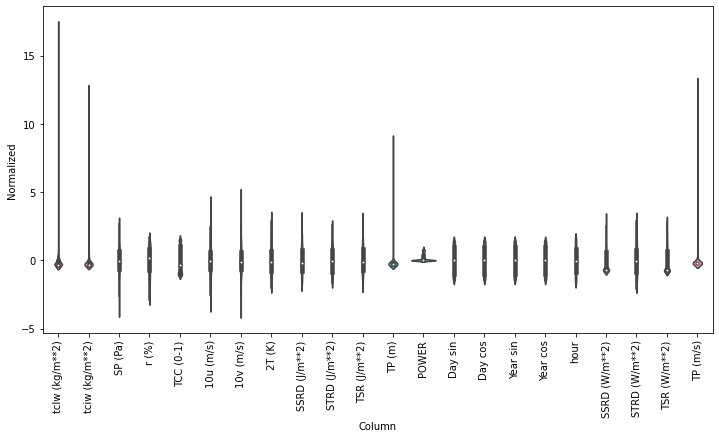

In [ ]:
# Distribution of features for training data at zone 1
df_std = train1_df.copy()
df_std = df_std.melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12,6))
ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
_ = ax.set_xticklabels(train1_df.keys(), rotation=90)
plt.savefig("norm.png")

# 3 Data Windowing

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df,
                 label_columns=None):
        # Store the raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
        
        # Work out the window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def __repr__(self):
        return "\n".join([
            f"Total window size: {self.total_window_size}",
            f"Input indices: {self.input_indices}",
            f"Label indices: {self.label_indices}",
            f"Label column name(s): {self.label_columns}"])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col="POWER", max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12,8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f"{plot_col} [normed]")
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label="Inputs", marker=".", zorder=-10)
            
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
            
            if label_col_index is None:
                continue
            
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors="k", label="Labels", c="#2ca02c", s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices,
                            predictions[n, :, label_col_index],
                            marker="X", edgecolors="k", label="Predictions",
                            c="#ff7f0e", s=64)
            
            if n == 0:
                plt.legend()
        
        plt.xlabel("Time [h]")

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)
        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        # Get and cache an example batch of `inputs, labels` for plotting
        result = getattr(self, "_example", None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

# 4 Models

## 4.1 Hyperparameters

In [ ]:
INPUT_WIDTH = 24
SHIFT = 24
SELECTED_COLS = max_corr_cols[:8].append(pd.Index(["POWER"]))
MAX_EPOCHS = 20

In [ ]:
w1 = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=1,
    shift=SHIFT,
    train_df=train1_df[SELECTED_COLS],
    val_df=val1_df[SELECTED_COLS],
    test_df=test1_df[SELECTED_COLS],
    label_columns=["POWER"]
)
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['POWER']

In [ ]:
w2 = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=1,
    shift=SHIFT,
    train_df=train2_df[SELECTED_COLS],
    val_df=val2_df[SELECTED_COLS],
    test_df=test2_df[SELECTED_COLS],
    label_columns=["POWER"]
)
w3 = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=1,
    shift=SHIFT,
    train_df=train3_df[SELECTED_COLS],
    val_df=val3_df[SELECTED_COLS],
    test_df=test3_df[SELECTED_COLS],
    label_columns=["POWER"]
)

In [ ]:
# Training procedure function
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                      patience=patience,
                                                      mode="min")
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [ ]:
# Results of models
val_performance1 = {}
performance1 = {}
val_performance2 = {}
performance2 = {}
val_performance3 = {}
performance3 = {}

## 4.2 Baseline Model

In [ ]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        print(inputs.shape)
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=-1)

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance1['Baseline'] = baseline.evaluate(w1.val)
performance1['Baseline'] = baseline.evaluate(w1.test, verbose=0)

(None, 24, 9)
67/67 [==============================] - 1s 4ms/step - loss: 0.1054 - mean_absolute_error: 0.2073


In [ ]:
val_performance2['Baseline'] = baseline.evaluate(w2.val)
performance2['Baseline'] = baseline.evaluate(w2.test, verbose=0)
val_performance3['Baseline'] = baseline.evaluate(w3.val)
performance3['Baseline'] = baseline.evaluate(w3.test, verbose=0)

67/67 [==============================] - 0s 4ms/step - loss: 0.1200 - mean_absolute_error: 0.2296


## 4.3 Linear Model

In [ ]:
def linear():
    return tf.keras.Sequential([
        tf.keras.layers.Dense(units=1)
    ])

In [ ]:
linear1 = linear()
compile_and_fit(linear1, w1)

IPython.display.clear_output()

val_performance1["Linear"] = linear1.evaluate(w1.val)
performance1["Linear"] = linear1.evaluate(w1.test, verbose=0)

67/67 [==============================] - 0s 4ms/step - loss: 0.0539 - mean_absolute_error: 0.1930


In [ ]:
linear2 = linear()
linear3 = linear()

compile_and_fit(linear2, w2)
IPython.display.clear_output()

compile_and_fit(linear3, w3)
IPython.display.clear_output()

val_performance2["Linear"] = linear2.evaluate(w2.val)
performance2["Linear"] = linear2.evaluate(w2.test, verbose=0)

val_performance3["Linear"] = linear3.evaluate(w3.val)
performance3["Linear"] = linear3.evaluate(w3.test, verbose=0)

67/67 [==============================] - 0s 5ms/step - loss: 0.0628 - mean_absolute_error: 0.2179


## 4.4 Dense Model

In [ ]:
def dense():
    model = multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
    ])
    return model

In [ ]:
dense1 = dense()

compile_and_fit(dense1, w1)
IPython.display.clear_output()

val_performance1["Dense"] = dense1.evaluate(w1.val)
performance1["Dense"] = dense1.evaluate(w1.test, verbose=0)

67/67 [==============================] - 0s 4ms/step - loss: 0.0127 - mean_absolute_error: 0.0577


In [ ]:
dense2 = dense()
dense3 = dense()

compile_and_fit(dense2, w2)
IPython.display.clear_output()

compile_and_fit(dense3, w3)
IPython.display.clear_output()

val_performance2["Dense"] = dense2.evaluate(w2.val)
performance2["Dense"] = dense2.evaluate(w2.test, verbose=0)

val_performance3["Dense"] = dense3.evaluate(w3.val)
performance3["Dense"] = dense3.evaluate(w3.test, verbose=0)

67/67 [==============================] - 0s 5ms/step - loss: 0.0128 - mean_absolute_error: 0.0580


## 4.5 Convolutional Neural Network

In [ ]:
def cnn():
    return tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=16,
                            kernel_size=(INPUT_WIDTH,),
                            activation='relu'),
        tf.keras.layers.Dense(units=1, activation="sigmoid"),
    ])

In [ ]:
cnn1 = cnn()

compile_and_fit(cnn1, w1)
IPython.display.clear_output()

val_performance1["Conv"] = cnn1.evaluate(w1.val)
performance1["Conv"] = cnn1.evaluate(w1.test, verbose=0)

67/67 [==============================] - 0s 4ms/step - loss: 0.0115 - mean_absolute_error: 0.0546


In [ ]:
cnn2 = cnn()
cnn3 = cnn()

compile_and_fit(cnn2, w2)
IPython.display.clear_output()

compile_and_fit(cnn3, w3)
IPython.display.clear_output()

val_performance2["Conv"] = cnn2.evaluate(w2.val)
performance2["Conv"] = cnn2.evaluate(w2.test, verbose=0)

val_performance3["Conv"] = cnn3.evaluate(w3.val)
performance3["Conv"] = cnn3.evaluate(w3.test, verbose=0)

67/67 [==============================] - 0s 5ms/step - loss: 0.0116 - mean_absolute_error: 0.0596


## 4.6 Recurrent Neural Network

In [ ]:
def lstm():
    return tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(32, return_sequences=True),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1, activation="sigmoid")
    ])

In [ ]:
lstm1 = lstm()

compile_and_fit(lstm1, w1)
IPython.display.clear_output()

val_performance1["LSTM"] = lstm1.evaluate(w1.val)
performance1["LSTM"] = lstm1.evaluate(w1.test, verbose=0)

67/67 [==============================] - 1s 11ms/step - loss: 0.0123 - mean_absolute_error: 0.0570


In [ ]:
lstm2 = lstm()
lstm3 = lstm()

compile_and_fit(lstm2, w2)
IPython.display.clear_output()

compile_and_fit(lstm3, w3)
IPython.display.clear_output()

val_performance2["LSTM"] = lstm2.evaluate(w2.val)
performance2["LSTM"] = lstm2.evaluate(w2.test, verbose=0)

val_performance3["LSTM"] = lstm3.evaluate(w3.val)
performance3["LSTM"] = lstm3.evaluate(w3.test, verbose=0)

67/67 [==============================] - 1s 7ms/step - loss: 0.0149 - mean_absolute_error: 0.0607


# 5 Results

In [ ]:
def results_df(res):
    models = res.keys()
    results = {"RMSE": [], "MAE": []}
    for m in models:
        results["RMSE"].append(np.sqrt(res[m][0]))
        results["MAE"].append(res[m][1])
    return pd.DataFrame(results, models)

In [ ]:
def plot_results(val, test, output_file=None):
    x = np.arange(len(test))
    width = 0.3
    mse_index = 0
    mae_index = 1
    
    val_rmse = np.sqrt([v[mse_index] for v in val.values()])
    test_rmse = np.sqrt([v[mse_index] for v in test.values()])

    val_mae = [v[mae_index] for v in val.values()]
    test_mae = [v[mae_index] for v in test.values()]

    plt.subplot(2, 1, 1)
    plt.xticks([], [])
    plt.ylabel("RMSE [Power, normalized]")
    plt.bar(x - 0.17, val_rmse, width, label="Validation")
    plt.bar(x + 0.17, test_rmse, width, label="Test")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.xticks(ticks=x, labels=test.keys(), rotation=45)
    plt.ylabel("MAE [Power, normalized]")
    plt.bar(x - 0.17, val_mae, width, label="Validation")
    plt.bar(x + 0.17, test_mae, width, label="Test")

    if output_file is not None:
        plt.savefig(output_file)

    plt.show()

In [ ]:
def print_best(res_df):
    value = res_df.min()
    metric = value.index
    model = res_df.idxmin()
    print(f"{metric[0]:6s}{model[0]:6s}{value[0]:.4f}")
    print(f"{metric[1]:6s}{model[1]:6s}{value[1]:.4f}")

Best val. performance:
RMSE  Conv  0.1073
MAE   Conv  0.0546
Best test performance:
RMSE  Conv  0.1112
MAE   Conv  0.0577


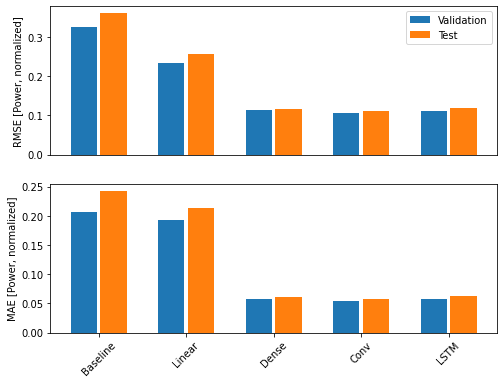

In [ ]:
val_res1 = results_df(val_performance1)
test_res1 = results_df(performance1)
print("Best val. performance:")
print_best(val_res1)
print("Best test performance:")
print_best(test_res1)
plot_results(val_performance1, performance1, "zone1_results.png")

Best val. performance:
RMSE  Conv  0.1019
MAE   Dense 0.0522
Best test performance:
RMSE  Conv  0.1179
MAE   Dense 0.0615


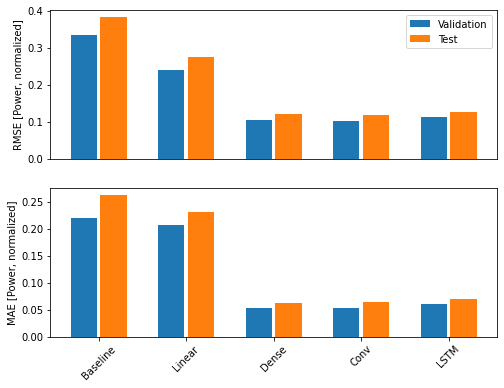

In [ ]:
val_res2 = results_df(val_performance2)
test_res2 = results_df(performance2)
print("Best val. performance:")
print_best(val_res2)
print("Best test performance:")
print_best(test_res2)
plot_results(val_performance2, performance2, "zone2_results.png")

Best val. performance:
RMSE  Conv  0.1078
MAE   Dense 0.0580
Best test performance:
RMSE  Conv  0.1194
MAE   Dense 0.0662


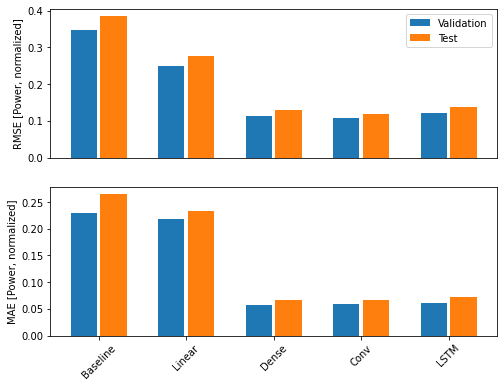

In [ ]:
val_res3 = results_df(val_performance3)
test_res3 = results_df(performance3)
print("Best val. performance:")
print_best(val_res3)
print("Best test performance:")
print_best(test_res3)
plot_results(val_performance3, performance3, "zone3_results.png")